# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [3]:
! pip install torch torchvision torchsummary sklearn

    100% |████████████████████████████████| 591.8MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61014000 @  0x7ff87467a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 2.0MB 6.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [5]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [6]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

In [8]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 5.9MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


### Data preprocessing

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
grayscale_images = []
colorscale_images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    if len(current_img_vector.shape)==2: # If shape is (128, 128) (no color channels)
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        grayscale_images+=[img_num]
    else:
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        colorscale_images+=[img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

#merging_method : 
# 0 : Convert  a colored image to grey image
# 1 : Complete a grey    image with zeros   to a have colored image
# 2 : Complete a grey    image with himself to a have colored image


class imageDataset(Dataset):
    def __init__(self, data_basenames, merging_method = 2, channels = 3, height = 128, width = 128, transforms = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
    #    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)
        self.merging_method = merging_method

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if(self.merging_method == 0 ):
            
            if img.shape[0] == 3:
              img = img[0] + img[1] + img[2]
              img /= 3
              img = img.reshape((1, 224, 224))
              
        elif(self.merging_method == 1):
          
            if img.shape[0] == 1:  # change graysclae images to RGB
                zeros_torser = torch.zeros([1, 224, 224])
                img = torch.cat((img,zeros_torser, zeros_torser),0)
                
        elif(self.merging_method == 2):  
            if img.shape[0] == 1:  # change graysclae images to RGB
                img = torch.cat((img,img, img),0)
        
            
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 128

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
train_dataset = imageDataset(images[:index_cut], merging_method = 2)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(images[index_cut:], merging_method = 2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

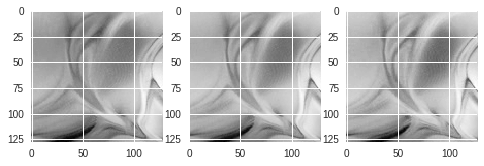

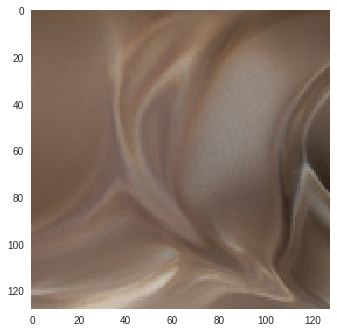

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels: []


In [15]:
# 3 channel show
data, target = next(train_loader.__iter__()) # Iteration works!

d0 = data[0]
t0 = target[0]

f, axs = plt.subplots(1,3)
axs[0].imshow(d0[0])
axs[1].imshow(d0[1])
axs[2].imshow(d0[2])
plt.show()

arr_ = d0.transpose(0,-1)
arr_ = np.rot90(arr_, 3)
arr_ = np.flip(arr_, axis=1)
plt.imshow(arr_)
plt.grid(None)
plt.show()
print(t0)
print("labels:", oneHotTransformer.toVocabulary(t0))

### Models

First, simple CNN architecture( exercise 3)

In [16]:

class sim_cnn_v1(nn.Module):
    def __init__(self, nclass = 14, input_channels=3):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(30*30*32, 30*32)
        self.fc2 = nn.Linear(30*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28800, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
       BatchNorm2d-2         [-1, 16, 126, 126]              32
              ReLU-3         [-1, 16, 126, 126]      

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14, input_channels=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn()

In [0]:
class deep_cnn_v2(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = deep_cnn_v2()

In [20]:
class deep_cnn_v3(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3)
        )
        self.fc1 = nn.Linear( 576, 32)
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = deep_cnn_v3(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v3(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=32, out_features=14, bias=Tru

In [21]:
class deep_cnn_v4(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=7),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v4(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v4(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=14, bias=True)
  )
)
----------------

In [22]:
class deep_cnn_v5(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v5(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=14, bias=True)
  )
)
----------------

In [0]:
# TODO
class lstm(nn.Module):
    pass

### Training

In [0]:

class Model_processing:
    def __init__(self,model, parameter_lr, train_loader, test_loader ):
        self.model = model
        self.parameter_lr = parameter_lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), betas=(0.9, 0.999), eps=1e-8, lr = self.parameter_lr) #Adam
        self.criterion = nn.MultiLabelSoftMarginLoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def processing(self):
        train_loss, val_loss = [], []
        for i in range(1,1+epoch):
            self.train_net( i, train_loss, 10)
            self.validate( val_loss, True)
        return train_loss, val_loss

    def train_net(self, epoch, trainLoss, interval):
        # set model to train
        self.model.train()
        loss = 0
        #acc = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            
            data = data.to(device) # to GPU
            target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.

            # set zero gradient buffer
            self.optimizer.zero_grad()

            # compute the output and Loss
            output = self.model(data)
            Loss = self.criterion(output, target)

            # back prop
            Loss.backward()

            # update weights
            self.optimizer.step()
            # print information
            if batch_idx % interval == 0:
                print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(self.train_loader)*len(data), batch_idx/len(self.train_loader)*100, Loss.data.item()))   

            loss += Loss
            torch.save(self.model.state_dict(), 'model.pkl')
        loss/=len(self.train_loader)
        trainLoss.append(loss)

    def validate(self,  lossv, verbose):
      loss, acc, prec, rec = 0,0,0,0
      for i, sample in enumerate(self.test_loader):
        inputv, targetv = sample
        inputv = inputv.to(device)
        output = self.model(inputv)

        loss += self.criterion(output, targetv.data.to(device).float()).data.item()

      loss /= len(self.test_loader)

      lossv.append(loss)

      if verbose:
        print('Validation set: Average loss: {:.4f}\n'.format(
                loss))

In [29]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn(input_channels=3).to(device)
#model = deep_cnn_bis(input_channels=3).to(device)
#model = lstm()
epoch = 5

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn



model_one_layer_cnn = one_layer_cnn().to(device)
md_pro_one_layer_cnn = Model_processing(model_one_layer_cnn, learning_rate, train_loader, test_loader )
train_loss_one_layer_cnn, val_loss_one_layer_cnn = md_pro_one_layer_cnn.processing()


model_sim_cnn = sim_cnn_v1().to(device)
md_pro_sim_cnn = Model_processing(model_sim_cnn, learning_rate, train_loader, test_loader )
train_loss_sim_cnn, val_loss_sim_cnn = md_pro_sim_cnn.processing()

model_cnn = deep_cnn(input_channels=3).to(device)
md_pro_cnn = Model_processing(model_cnn, learning_rate, train_loader, test_loader )
train_loss_cnn, val_loss_cnn = md_pro_cnn.processing()

model_cnn_v2 = deep_cnn_v2(input_channels=3).to(device)
md_pro_cnn_v2 = Model_processing(model_cnn_v2, learning_rate, train_loader, test_loader )
train_loss_cnn_v2, val_loss_cnn_v2 = md_pro_cnn_v2.processing()

model_cnn_v3 = deep_cnn_v3(input_channels=3).to(device)
md_pro_cnn_v3 = Model_processing(model_cnn_v3, learning_rate, train_loader, test_loader )
train_loss_cnn_v3, val_loss_cnn_v3 = md_pro_cnn_v3.processing()


model_cnn_v4 = deep_cnn_v4(input_channels=3).to(device)
md_pro_cnn_v4 = Model_processing(model_cnn_v4, learning_rate, train_loader, test_loader )
train_loss_cnn_v4, val_loss_cnn_v4 = md_pro_cnn_v4.processing()



model_cnn_v5 = deep_cnn_v5(input_channels=3).to(device)
md_pro_cnn_v5 = Model_processing(model_cnn_v5, learning_rate, train_loader, test_loader )
train_loss_cnn_v5, val_loss_cnn_v5 = md_pro_cnn_v5.processing()


Train Epoch: 1 [0/16000 0%]	Loss: 0.929795
Train Epoch: 1 [1280/16000 8%]	Loss: 0.693802
Train Epoch: 1 [2560/16000 16%]	Loss: 0.693328
Train Epoch: 1 [3840/16000 24%]	Loss: 0.693178
Train Epoch: 1 [5120/16000 32%]	Loss: 0.693175
Train Epoch: 1 [6400/16000 40%]	Loss: 0.693170
Train Epoch: 1 [7680/16000 48%]	Loss: 0.693170
Train Epoch: 1 [8960/16000 56%]	Loss: 0.693164
Train Epoch: 1 [10240/16000 64%]	Loss: 0.693174
Train Epoch: 1 [11520/16000 72%]	Loss: 0.693174
Train Epoch: 1 [12800/16000 80%]	Loss: 0.693352
Train Epoch: 1 [14080/16000 88%]	Loss: 0.693191
Train Epoch: 1 [15360/16000 96%]	Loss: 0.693163
Validation set: Average loss: 0.6932

Train Epoch: 2 [0/16000 0%]	Loss: 0.693177
Train Epoch: 2 [1280/16000 8%]	Loss: 0.693187
Train Epoch: 2 [2560/16000 16%]	Loss: 0.693168
Train Epoch: 2 [3840/16000 24%]	Loss: 0.693179
Train Epoch: 2 [5120/16000 32%]	Loss: 0.693152
Train Epoch: 2 [6400/16000 40%]	Loss: 0.693172
Train Epoch: 2 [7680/16000 48%]	Loss: 0.693162
Train Epoch: 2 [8960/16000 

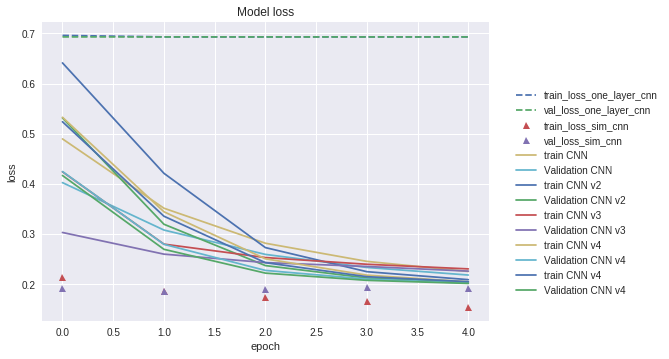

In [30]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate


plt.title("Model loss")



plt.plot(train_loss_one_layer_cnn,"--", label="train_loss_one_layer_cnn")
plt.plot(val_loss_one_layer_cnn, "--", label="val_loss_one_layer_cnn")

plt.plot(train_loss_sim_cnn,"^", label="train_loss_sim_cnn")
plt.plot(val_loss_sim_cnn,"^", label="val_loss_sim_cnn")

plt.plot(train_loss_cnn, label="train CNN ")
plt.plot(val_loss_cnn, label="Validation CNN")


plt.plot(train_loss_cnn_v2, label="train CNN v2")
plt.plot(val_loss_cnn_v2, label="Validation CNN v2")


plt.plot(train_loss_cnn_v3, label="train CNN v3")
plt.plot(val_loss_cnn_v3, label="Validation CNN v3")

plt.plot(train_loss_cnn_v4, label="train CNN v4")
plt.plot(val_loss_cnn_v4, label="Validation CNN v4")

plt.plot(train_loss_cnn_v5, label="train CNN v4")
plt.plot(val_loss_cnn_v5, label="Validation CNN v4")

plt.legend(bbox_to_anchor=(1.4,0.8), loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

### Treshold optimization
DISCLAIMER : Does not work as intended.

In that part we strive to optimize the treshold of activation of each label, in order to maximize F1 score

In [0]:
# Concatenating all the batches _label_ output in order to not compute it several 
# times for F1 score optimization.

def make_pred(bounded_output_all, tresholds):
  return bounded_output_all.data.gt(tresholds) # Activation

for i, (inputv, targetv) in enumerate(test_loader):
  inputv = inputv.to(device)
  targetv = targetv.to(device)
  bounded_output = torch.sigmoid(model(inputv))
  if i==0:
    bounded_output_all = bounded_output
    truth_all = targetv
  else:
    bounded_output_all = torch.cat((bounded_output_all, bounded_output), 0)   
    truth_all = torch.cat((truth_all, targetv), 0)

RuntimeError: ignored

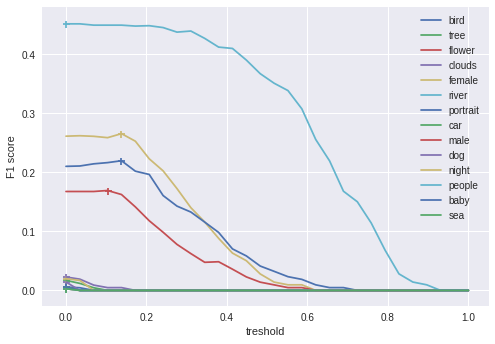

tresholds: [0.0, 0.0, 0.0, 0.0, 0.13793103448275862, 0.0, 0.13793103448275862, 0.0, 0.10344827586206896, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
# Optimizing treshold for each label : Iterating over labels
# Dropout layers have the effect of making a network not returning the same output for a same output at different runs
# This means that F1 score function will be "noisy", ie it won't be a smooth curve.
# This makes optimization much more complicate than simply a SGD descent. To be tolerant of that case, 
# we check all values in order to not be tricked by noise, and choose the observed maximum.


def compute_f1(pred, target):
  """ Yields same result as scikit learn's micro averaged f1 but without
  a warning. """
  tp = (pred + target.long()).eq(2).sum()
  fp = (pred - target.data.to(device).long()).eq(1).sum()
  fn = (pred - target.data.to(device).long()).eq(-1).sum()
  tn = (pred + target.data.to(device).long()).eq(0).sum()

  if tp+fp!=0:
    prec = tp.float() / (tp + fp)
  else:
    prec = 0.0
  if tp+fn != 0:
    rec = tp.float() / (tp + fn)
  else:
    rec = 0.0
  if (prec+rec)==0:
    f1 = 0.0
  else: 
    f1tensor = 2*(prec*rec)/(prec+rec)
    f1 = f1tensor.data.item()
  return f1
    
class tresholdOptimizer():
  def __init__(self, paces=30, max=1): # High pace means more precision but slower computation
    wrapper = lambda array: [[elem] for elem in array]
    self.tresholds = np.linspace(0,max,paces)
    
    for i in range(14): # label
      current_tresholds = [1 for _ in range(14)] # 1 so other labels are never activated,
                                                 # and only the currently studied treshold make the f1 vary
      f1 = []
      for t in self.tresholds:
        current_tresholds[i] = t
        tresholds_as_tensor = torch.Tensor(current_tresholds).to(device) 
        bounded_output_all_for_i = bounded_output_all[:, i]
        pred_all = make_pred(bounded_output_all, tresholds_as_tensor)
        f1_curr = compute_f1(truth_all, pred_all) # For some reason sklearn echoes a warning, but both this function and sklearn's yield the same result
        f1.append(f1_curr)
      if i==0:
        self.tab = [f1]
      else:
        self.tab.append(f1)
        
  def view(self):
    plt.xlabel("treshold")
    plt.ylabel("F1 score")
    for label in range(0,14):
      plt.plot(self.tresholds , self.tab[label], label=oneHotTransformer.vocabulary[label])
      imax = np.argmax(self.tab[label])
      plt.scatter(self.tresholds[imax], self.tab[label][imax], marker="+")
    plt.legend()
    plt.show()

  def get_best_tresholds(self):
    res = []
    for label in range(0,14):
      imax=np.argmax(self.tab[label])
      res.append(self.tresholds[imax])
    return res

treshold_opt = tresholdOptimizer()
treshold_opt.view()
print("tresholds:", treshold_opt.get_best_tresholds())

In [0]:
# CAREFUL! It appears that my implementation does not work. A constant treshold of 0.2
# appear to yield much better f1 than my implementation. Some fields are detected as performing best with 0, 
# with our optimizer which is wrong as shown below.

# tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!


tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!)      
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)
f1 = compute_f1(pred_all.long(), truth_all)
#f1 = sklearn.metrics.f1_score(truth_all.cpu(), pred_all.cpu(), average="micro") # same result
print("tresholds", tresholds_as_tensor)
print("F1 score : {:.2f}%\n".format(f1*100))
      
tresholds = [0.3, 0.3,
 0.3, 0.3,
 0.3, 0.3,
 0.3, 0.3,
 0.3, 0.3,
 0.3, 0.3,
 0.3, 0.3]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)
f1 = compute_f1(pred_all.long(), truth_all)
print("tresholds", tresholds_as_tensor)
print("F1 score : {:.2f}%\n".format(f1*100))


tresholds tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.1379, 0.0000, 0.1379, 0.0000, 0.1034,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
F1 score : 19.13%

tresholds tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000], device='cuda:0')
F1 score : 52.24%



In [0]:
# Result with """ Optimized """ tresholds
from sklearn.metrics import classification_report
tresholds = treshold_opt.get_best_tresholds() # Is actually not the best..!)      
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)

target_names = oneHotTransformer.vocabulary
#report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names, output_dict=True)
report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names)
print("with tresholds", list(zip(target_names, tresholds)))
print(report)
# Apparently, the optimization is good for all f1-score avg _EXCEPT_ micro (compare with the cell below)

with tresholds [('bird', 0.0), ('tree', 0.0), ('flower', 0.0), ('clouds', 0.0), ('female', 0.13793103448275862), ('river', 0.0), ('portrait', 0.13793103448275862), ('car', 0.0), ('male', 0.10344827586206896), ('dog', 0.0), ('night', 0.0), ('people', 0.0), ('baby', 0.0), ('sea', 0.0)]
              precision    recall  f1-score   support

        bird       0.01      1.00      0.01         2
        tree       0.02      1.00      0.04         6
      flower       0.00      1.00      0.01         1
      clouds       0.03      1.00      0.05         8
      female       0.37      0.95      0.53        92
       river       0.00      1.00      0.01         1
    portrait       0.33      0.93      0.49        74
         car       0.01      1.00      0.01         2
        male       0.21      1.00      0.35        59
         dog       0.02      1.00      0.03         5
       night       0.02      1.00      0.05         7
      people       0.56      1.00      0.72       159
        baby

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [0]:
# Result with rubbish tresholds
from sklearn.metrics import classification_report
tresholds = [0.2 for _ in range(14)]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
pred_all = make_pred(bounded_output_all, tresholds_as_tensor)

target_names = oneHotTransformer.vocabulary
#report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names, output_dict=True)
report = classification_report(truth_all.cpu(), pred_all.cpu(), target_names=target_names)
print("with tresholds", list(zip(target_names, tresholds)))
print(report)

with tresholds [('bird', 0.2), ('tree', 0.2), ('flower', 0.2), ('clouds', 0.2), ('female', 0.2), ('river', 0.2), ('portrait', 0.2), ('car', 0.2), ('male', 0.2), ('dog', 0.2), ('night', 0.2), ('people', 0.2), ('baby', 0.2), ('sea', 0.2)]
              precision    recall  f1-score   support

        bird       0.00      0.00      0.00         2
        tree       0.00      0.00      0.00         6
      flower       0.00      0.00      0.00         1
      clouds       0.00      0.00      0.00         8
      female       0.41      0.74      0.53        92
       river       0.00      0.00      0.00         1
    portrait       0.37      0.77      0.50        74
         car       0.00      0.00      0.00         2
        male       0.21      0.64      0.31        59
         dog       0.00      0.00      0.00         5
       night       0.00      0.00      0.00         7
      people       0.56      0.99      0.71       159
        baby       0.00      0.00      0.00         2
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [0]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    tresholds = treshold_opt.get_best_tresholds()
    tresholds_as_tensor = torch.Tensor(tresholds).to(device) 
    pred = output.data.gt(tresholds_as_tensor) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 

In [0]:
img_shape = {}
for current_img_path in all_img_paths:
    current_img_vector =  plt.imread( current_img_path )
    
    #if (str(str(current_img_vector.shape)) == "(128, 128)"):
    #    print(current_img_vector.shape, current_img_path)
    #    unicolor_name = current_img_path
    #    unicolor = current_img_vector
    if(str(current_img_vector.shape) not in img_shape.keys()):
        img_shape[str(current_img_vector.shape)] = []
    img_shape[str(current_img_vector.shape)].append(current_img_path)

In [0]:
img_shape.keys()

dict_keys(['(128, 128, 3)', '(128, 128)'])

RGB images

In [0]:
img_vector_3 = {}
#To process with all images, don't forget to remove "[:10]"
for current_img_path in img_shape["(128, 128, 3)"][:1024]:
    I =  plt.imread( current_img_path )
    modified_current_img_vector = np.array([I[:,:,0], I[:,:,1], I[:,:,2]])
    img_vector_3[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = modified_current_img_vector


Grey images

In [0]:
img_vector_1 = {}

for current_img_path in img_shape["(128, 128)"]:
    current_img_vector =  plt.imread( current_img_path )
    #Do we have to reshape to (128*128) or (1,128*128) ?
    img_vector_1[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = np.reshape(current_img_vector, (1,128,128))


In [0]:
nb_img_vector_3 = len(img_vector_3.keys())

Create train dataset and test dataset from 3 dimention images

In [0]:

batch_size = 64

img_names = rd.sample(list(img_vector_3.keys()), nb_img_vector_3)
train_img_name = img_names[ :int(nb_img_vector_3 * 0.8)]
test_img_name = img_names[ int(nb_img_vector_3 * 0.8):]


X_Train = torch.from_numpy(np.array([ [ img_vector_3[ train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(train_img_name)/batch_size))]))
y_Train = torch.from_numpy(np.array([ [ img_labels[   train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(train_img_name)/batch_size))]))

X_Test = torch.from_numpy(np.array([ [ img_vector_3[ test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(test_img_name)/batch_size))]))
y_Test = torch.from_numpy(np.array([ [ img_labels[   test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(test_img_name)/batch_size))]))

X_Train = X_Train.type('torch.FloatTensor')
y_Train = y_Train.type('torch.FloatTensor')
X_Test = X_Test.type('torch.FloatTensor')
y_Test = y_Test.type('torch.FloatTensor')


In [0]:
print(X_Train.shape)
print(y_Train.shape)
print(X_Test.shape)
print(y_Test.shape)

torch.Size([12, 64, 3, 128, 128])
torch.Size([12, 64, 14])
torch.Size([3, 64, 3, 128, 128])
torch.Size([3, 64, 14])


In [0]:
X_Test.shape

torch.Size([3, 64, 3, 128, 128])

In [0]:
X_Test[0].shape

torch.Size([64, 3, 128, 128])

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [0]:
to_test_path = 'to_test'
dl_file = 'dl2018-image-test.zip'
dl_url = 'https://users.aalto.fi/~mvsjober/misc/'

zip_path = os.path.join(to_test_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=to_test_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(to_test_path)

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
order = ['baby', # given order, most likely different from the order constructed
 'bird',         # automatically in the preprocessing part.
 'car',
 'clouds',
 'dog',
 'female',
 'flower',
 'male',
 'night',
 'people',
 'portrait',
 'river',
 'sea',
 'tree']
# Permutation table (arrays' indices to permute) 
switch = [0 for _ in range(14)]
for i in range(14):
  searched =  order[i]
  switch[i] = oneHotTransformer.vocabulary.index(searched)

def batch_output_in_right_order(batch_pred, order_switch):
  return batch_pred[:, order_switch]
  

# Example for one batch
inputv, targetv = next(test_loader.__iter__())
inputv = inputv.to(device)
best_tresholds_as_tensor = torch.Tensor([0.2]*14).to(device)
batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor

batch_right_order = batch_output_in_right_order(batch_pred, switch)


Truth:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])
Labelled Truth:  ['female', 'portrait', 'people']
----------
new order ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
re ordered tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])


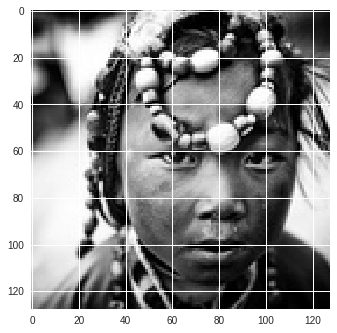

In [0]:
# Double check it works
print("Truth: ", targetv[0])
print("Labelled Truth: ", oneHotTransformer.toVocabulary(targetv[0]))

ex0 = batch_right_order[0]


print("-"*10)
print("new order", order)
#print(inputv.cpu().numpy()[0][0])


targetv_good_order = batch_output_in_right_order(targetv, switch)
t0 = targetv_good_order[0]
plt.imshow(inputv.cpu().numpy()[0][0], cmap="gray")
#print(batch_output_in_right_order(batch_pred, switch))
print("re ordered", t0)
plt.show()



In [0]:
images_path_test = "to_test/images/" 
image_files_test = [(images_path_test+f) for f in os.listdir(images_path_test) \
                if os.path.isfile(os.path.join(images_path_test, f))]

image_files_test = sorted(image_files_test)
def to_basename(rel_path):
  """ 'to_test/images/im20001.jpg' to '20001' """
  return rel_path[17:-4] # stripping 17 first chars and last 4 ones (extension of the file)
basenames_test = [to_basename(path) for path in image_files_test]
print(basenames_test[:10])

# load dataset
# TODO Need color and grayscale handling 

['20001', '20002', '20003', '20004', '20005', '20006', '20007', '20008', '20009', '20010']


In [0]:
inputv, targetv = next(test_loader.__iter__())
inputv = inputv.to(device)
model(inputv)
tresholds = treshold_opt.get_best_tresholds()
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor
print(batch_pred)

tensor([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]], device='cuda:0',
       dtype=torch.uint8)


In [0]:
def batchprediction_to_txt(pred):
  listpred = pred.data.tolist()
  res = ""
  for labels in listpred:
    stringified_labels = map(str, labels)
    res += " ".join(stringified_labels) + "\n"
  return res


batch_right_order = batch_output_in_right_order(batch_pred, switch)
print(batchprediction_to_txt(batch_right_order))
# TODO : iterate over dataset and write labels batch by batch with the above function

0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 1 0 1 0 0 0 0
0 0 0 0 0 1 0 0 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 1 0 1 0 1 0 0 0 0



In [0]:
np.savetxt('results.txt', y, fmt='%d')